3.1181648354722355e-20
2.5786304910193765e-17
3.0436340037748254e-15
7.425150292809705e-05


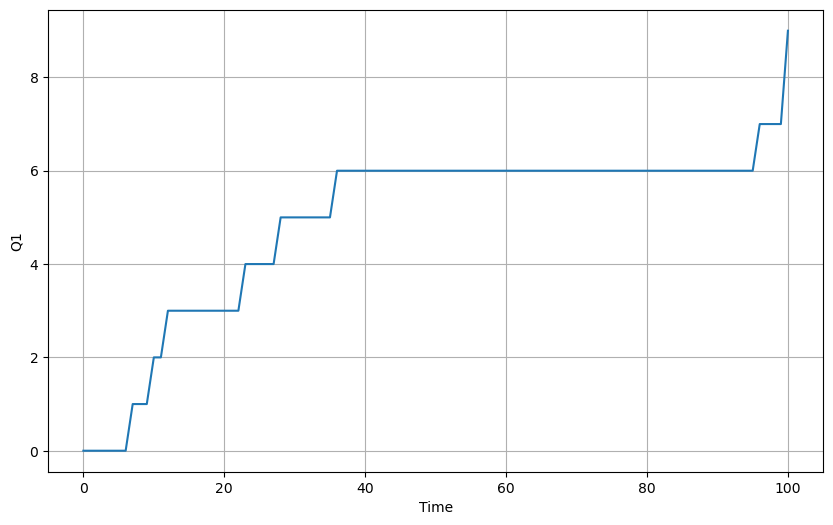

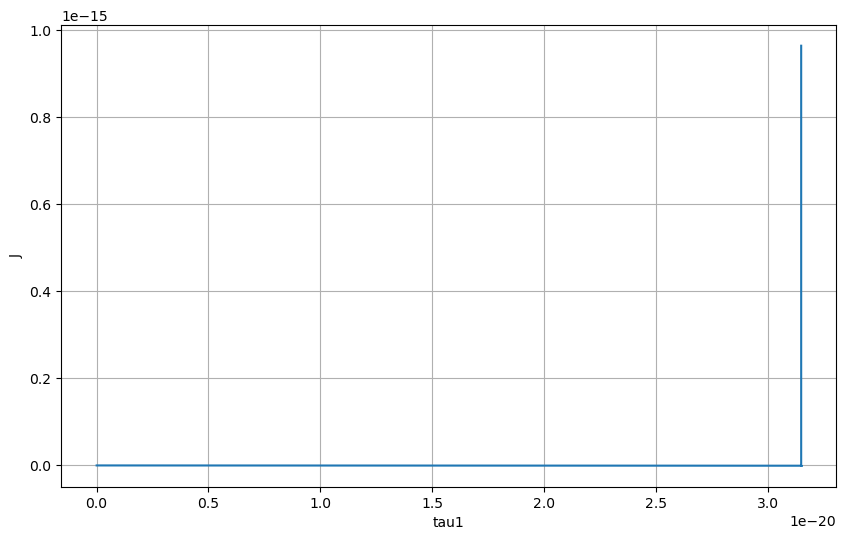

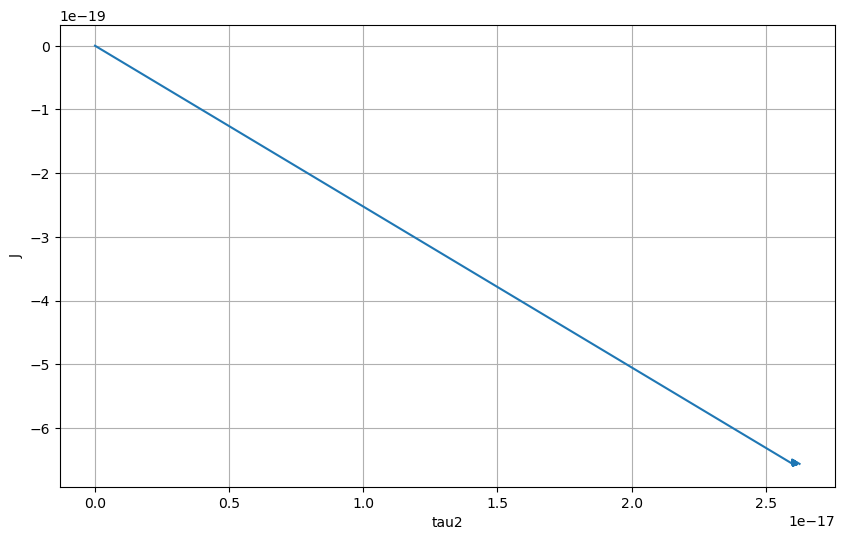

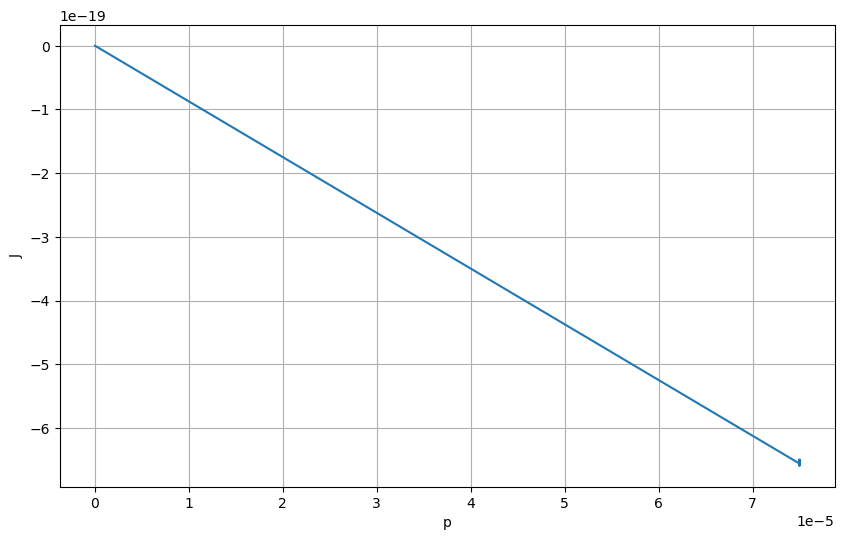

In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import Environment_Revised as Env
import matplotlib.pyplot as plt
import cvxpy as cp

# Initial parameters
P_max              = 0.00015   # Maximum transfer power of TX1 (watt)
TX1_Bandwidth      = 1e6       # TX1-RX1 Channel bandwidth (Hz)
RX1_Noise_Power    = 1e-13     # Power of noise in RX1 (watt)
Distance_TX1_RX1   = 100       # Distance between TX1 and RX1 (meter)
TX1_fading_samples = 1000      # Number of fading samples in the communication channel between TX1 and RX1
Lambda_a1          = 0.1  # Density of arrival data in TX1

com_round          =  3.1001460052367084e-15

ALPHA              = 1.5     # Path-loss exponent of communication and energy harvesting links

EH_eta             = 0.1     # Energy harvesting coefficient

B_max              = 0.1 # Maximum energy in the battery of TX2 in joules

EH_fading_samples  = 1000    # Number of fading samples in the energy harvesting channel between TX1 and TX2
Distance_TX1_TX2   = 10      # Distance between TX1 and TX2 (meter)

Distance_TX2_RX2   = 100     # Distance between TX2 and RX2 (meter)
TX2_fading_samples = 1000    # Number of fading samples in the communication channel between TX2 and RX2
RX2_Noise_Power    = 1e-13   # Noise power in RX2 (watt)
TX2_Bandwidth      = 1e6     # Bandwidth of the communication channel between TX2 and RX2 (Hz)
Lambda_a2          = 0.3 * 1e5 # Density of arrival data in TX2

beta               = 0.5     # Lyapunov parameter

T = 100     # Number of communication rounds

# Initialize queues
Q1 = np.zeros(T + 1) # Data of TX1
Q2 = np.zeros(T + 1) # Data of TX2
B  = np.zeros(T + 1) # Battery of TX2

x1 = com_round/3     #tau_1
x2 = com_round/3     #tau_2
x3 = com_round/3     #tau_eh 
x4 = P_max/3         #p_1_t

x1_values  = np.zeros(T + 1) 
x2_values  = np.zeros(T + 1) 
x3_values  = np.zeros(T + 1) 
x4_values  = np.zeros(T + 1) 
j_x4       = np.zeros(T + 1) 
j_x2       = np.zeros(T + 1) 
j_x1       = np.zeros(T + 1) 
for t in range(T):
   
    a1_t = np.random.poisson(Lambda_a1)
    a2_t = np.random.poisson(Lambda_a2)
    
    # TX1 processing
    RX1_Power, TX1_channel_gain  = Env.FadingChannel(x4, Distance_TX1_RX1, ALPHA, TX1_fading_samples)
    SNR_RX1, Rate_RX1, Data_TX1  = Env.calculate_transferred_data(RX1_Power, RX1_Noise_Power, TX1_Bandwidth, x1)
    Data_Transferred_TX1         = min(Data_TX1, Q1[t])
    Q1[t + 1]                    = Q1[t] - Data_Transferred_TX1 + a1_t
    
    # TX2 processing
    power_eh, EH_channel_gain   = Env.FadingChannel(P_max-x4, Distance_TX1_TX2, ALPHA, EH_fading_samples)
    Harvested_power_TX2         = EH_eta * power_eh
    Tx2_power                   = min(1000 / 3600, B[t] / x2)
    RX2_Power, TX2_channel_gain = Env.FadingChannel(Tx2_power, Distance_TX2_RX2, ALPHA, TX2_fading_samples)
    SNR_RX2, Rate_RX2, Data_TX2 = Env.calculate_transferred_data(RX2_Power, RX2_Noise_Power, TX2_Bandwidth, x2)
    Data_Transferred_TX2        = min(Data_TX2, Q2[t])
    Q2[t + 1]                   = Q2[t] - Data_Transferred_TX2 + a2_t
    Energy_consumption_TX2      = Tx2_power * x2
    B[t + 1]                    = B[t] - Energy_consumption_TX2 + (Harvested_power_TX2 * x3)
    B[t + 1]                    = min(B[t + 1], B_max)

    # x1 optimization in Alternating approach 
    x              = cp.Variable()
    xi_1           = np.mean(TX1_channel_gain) / RX1_Noise_Power
    xi_2           = np.mean(TX2_channel_gain) / RX2_Noise_Power 
    z1             = (TX1_Bandwidth**2) * ( np.log2( 1 + ( xi_1 * x4 ) ) )**2 
    z2             = -beta * x4
    z3             = ( x2**2 * (TX2_Bandwidth**2) * ( np.log2( 1 + ( xi_2 * B_max ) ) )**2 ) - (beta * x2 * B_max)
    objective      = cp.Minimize( (z1 * x**2) + (z2 * x) + z3 )
    constraints    = [ x >= 0, x <= (com_round - x2 - x3) ]
    problem        = cp.Problem(objective, constraints)
    problem.solve()
    x1             = x.value
    x1_values[t]   = x1
    j_x1[t]        = problem.value
    # x1 optimization in Alternating approach 

    # x2 optimization in Alternating approach 
    x              = cp.Variable()
    xi_1           = np.mean(TX1_channel_gain) / RX1_Noise_Power
    xi_2           = np.mean(TX2_channel_gain) / RX2_Noise_Power 
    z1             = (TX2_Bandwidth**2) * ( np.log2( 1 + ( xi_2 * B_max ) ) )**2 
    z2             = -beta * B_max
    z3             = ( x1**2 * (TX1_Bandwidth**2) * ( np.log2( 1 + ( xi_1 * x4 ) ) )**2 ) - (beta * x1 * x4)
    objective      = cp.Minimize( (z1 * x**2) + (z2 * x) + z3 )
    constraints    = [ x >= 0, x <= (com_round - x1 - x3) ]
    problem        = cp.Problem(objective, constraints)
    problem.solve()
    x2             = x.value
    x2_values[t]   = x2
    j_x2[t]        = problem.value
    # x2 optimization in Alternating approach

    # x3 optimization in Alternating approach
    x3             = com_round - x1 - x2
    x3_values[t]   = x3
    # x3 optimization in Alternating approach
    
    # x4 optimization in Alternating approach
    x0             = 0.5 * P_max
    x              = cp.Variable()
    xi_1           = np.mean(TX1_channel_gain) / RX1_Noise_Power
    xi_2           = np.mean(TX2_channel_gain) / RX2_Noise_Power 
    z1             = (TX1_Bandwidth**2) * x1**2
    z11            = (TX1_Bandwidth) * x1
    z2             = - beta * x1
    z3             = ( x2**2 * (TX2_Bandwidth**2) * ( np.log2( 1 + ( xi_2 * B_max ) ) )**2 ) - (beta * x2 * B_max)
    log_term       = cp.log(1 + (xi_1 * x0)) + (xi_1 * (x - x0)) / (1 + xi_1 * x0)
    objective      = cp.Minimize(( z1 * (log_term / np.log(2))**2 ) + (z2 * x) + z3 )
    constraints    = [x >= 0, x <= P_max]
    #constraints = [x >= 0,
                  #x <= P_max,
                  #(log_term / np.log(2)) <= Q1[t+1]/z11, 
                  #B[t] - (x2*B_max) + (EH_eta*x3 * EH_channel_gain * (P_max - x)) <= B_max,
                  #B_max*x2 <= B[t] - (x2*B_max) + (EH_eta*x3 * EH_channel_gain * (P_max - x))]
    problem        = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)
    x4             = x.value
    x4_values[t]   = x4
    j_x4[t]        = problem.value
    # x4 optimization in Alternating approach

print(np.mean(x1_values))
print(np.mean(x2_values))
print(np.mean(x3_values))
print(np.mean(x4_values))

# Plotting the queues over time
import matplotlib.pyplot as plt
time = np.arange(T+1)
plt.figure(figsize=(10, 6))
plt.plot(time, Q1, label='Queue')
plt.xlabel('Time')
plt.ylabel('Q1')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x1_values, j_x1, label='tau1')
plt.xlabel('tau1')
plt.ylabel('J')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x2_values, j_x2, label='tau2')
plt.xlabel('tau2')
plt.ylabel('J')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x4_values, j_x4, label='p')
plt.xlabel('p')
plt.ylabel('J')
plt.grid(True)
plt.show()
